In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = 1e-22
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}
        self.adsorption = []
        self.desorption = []
        self.diffusion = []

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        des = self.e_int_des * n_ij + self.e_des
        return ads, des

    def calculate_transition_rates(self, site):
        E_ads, E_des = self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100


            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / k_total)/self.factor
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.adsorption.append(self.events_count["adsorption"])
            self.desorption.append(self.events_count["desorption"])
            self.diffusion.append(self.events_count["diffusion"])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy

In [9]:
data = pd.read_csv('Datos recogidos.csv')
data

,T1,T2,T3,T4,T5,T6,T7,T8
0,7.356582,12.689700,16.63975891,18.50177591,20.48756861,23.81874933,27.99483371,30.050587
1,20.779935,25.251636,27.74874869,29.96534844,32.3689566,36.38963753,43.14944172,48.682691
2,17.067494,22.581181,27.20824559,29.44142746,31.86301674,35.91377591,42.7241494,48.187964
3,3.435141,5.324574,6.419099862,7.361824742,7.905974846,Nan,Nan,9.969490
4,5.160842,8.794261,10.64568387,Nan,14.07081694,Nan,17.65794955,18.402919
5,6.966551,9.896194,10.98039216,Nan,Nan,13.47174164,Nan,14.948097
6,6.687628,8.580372,Nan,10.14729951,Nan,11.87748422,Nan,13.744462
7,1.145313,1.696100,2.264219096,3.106471919,3.699599853,4.016499304,4.056284427,4.106165
8,6.008902,10.187933,12.13402572,13.93026706,15.14193867,16.9223541,20.3264095,23.376360
9,27.241766,41.585839,46.08447901,48.3110787,49.99238866,52.56751936,55.55139015,57.868871


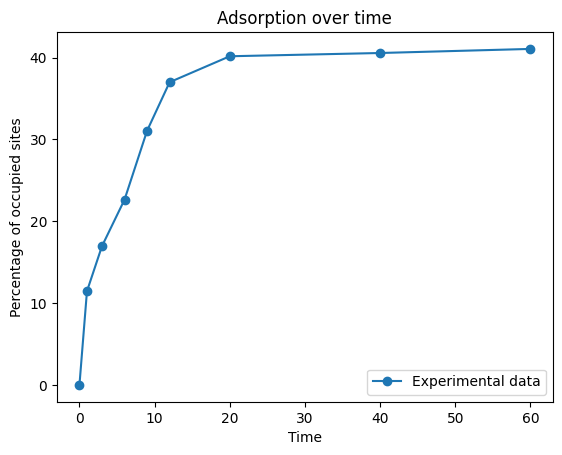

In [4]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)


time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

plt.plot(time_array, data.iloc[3], marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()
plt.show()

In [8]:
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964
3,0,11.453131,16.961002,22.642191,31.064719,36.995999,40.164993,40.562844,41.061651
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952


{'adsorption': 5827, 'desorption': 0, 'diffusion': 4663}
Saturation:  48.69387755102041 %


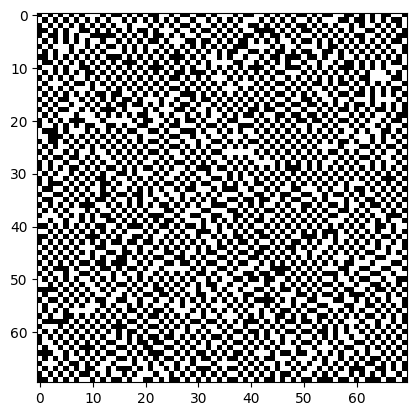

In [10]:
lattice_size = 70
T = 280
e_ads = -1.83
e_des = 1.23
e_diff = -0.579
e_int_abs = 0.8
e_int_des = 0.7
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,time_array=time_array)
occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()


ValueError: x and y must have same first dimension, but have shapes (9,) and (8,)

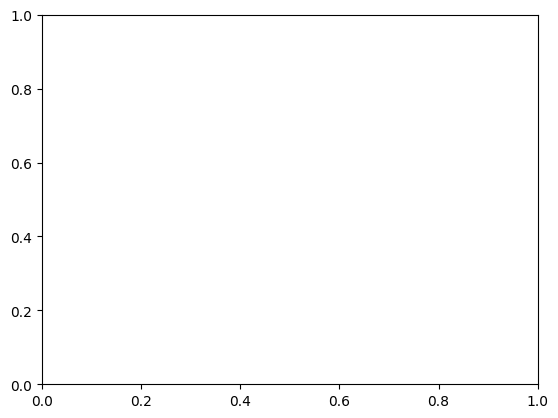

In [11]:
exp_data = data.iloc[3]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

In [19]:
base_params = {
    "T": 300,  
    "e_ads": -1.82,  
    "e_des": 1.25,  
    "e_diff": -0.579,  
    "e_int_abs": 0.608,  
    "e_int_des": 0.89
}
variability = 0.05

In [20]:
low_e_ads = min(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))
high_e_ads = max(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))

low_e_des = min(base_params["e_des"] * (1 - variability), base_params["e_des"] * (1 + variability))
high_e_des = max(base_params["e_des"] * (1 - variability), base_params["e_des"] * (1 + variability))

low_e_diff = min(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))
high_e_diff = max(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))

low_e_int_abs = min(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))
high_e_int_abs = max(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))

low_e_int_des = min(base_params["e_int_des"] * (1 - variability), base_params["e_int_des"] * (1 + variability))
high_e_int_des = max(base_params["e_int_des"] * (1 - variability), base_params["e_int_des"] * (1 + variability))

In [22]:
import numpy as np
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm

# Definir número de iteraciones
N_CALLS = 200

# Inicializar barra de progreso
progress_bar = tqdm(total=N_CALLS, desc="Optimización Bayesiana en Progreso", position=0)

# Variables para almacenar el mejor resultado
best_params = None
best_error = float("inf")

def loss_function(params):
    global start_time, best_params, best_error
    
    # Desempaquetar parámetros
    e_ads, e_des, e_diff, e_int_abs, e_int_des, lattice_size, T = params  

    # Ejecutar el modelo KMC
    kmc_model = KineticMonteCarlo(
        lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
        e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
        time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
    )
    kmc_model.run_simulation()

    # Calcular error
    simulated_data = np.array(list(kmc_model.occupancy.values()))
    error = np.mean((simulated_data - exp_data) ** 2)

    # Actualizar mejores parámetros si se encuentra un menor error
    if error < best_error:
        best_error = error
        best_params = params
        print(f"🟢 Nuevo mejor error: {best_error:.6f} con parámetros {best_params}")

    # Calcular tiempos estimados
    elapsed_time = time.time() - start_time
    avg_time_per_iter = elapsed_time / (progress_bar.n + 1)
    estimated_time_left = avg_time_per_iter * (N_CALLS - progress_bar.n - 1)

    # Agregar información en la barra de progreso
    progress_bar.set_postfix({
        "Tiempo transcurrido": f"{elapsed_time:.2f} s",
        "Tiempo restante": f"{estimated_time_left:.2f} s",
        "Mejor error": f"{best_error:.6f}"
    })
    
    progress_bar.update(1)

    return error

# Definir espacio de búsqueda
space = [
    Real(low_e_ads, high_e_ads, name="e_ads"),
    Real(low_e_des, high_e_des, name="e_des"),
    Real(low_e_diff, high_e_diff, name="e_diff"),
    Real(low_e_int_abs, high_e_int_abs, name="e_int_abs"),
    Real(low_e_int_des, high_e_int_des, name="e_int_des"),
    Integer(60, 100, name="lattice_size"),
    Real(280,350, name="T"),
]

# Iniciar optimización
start_time = time.time()
result = gp_minimize(loss_function, space, n_calls=N_CALLS, random_state=42)
progress_bar.close()

# Finalizar optimización
end_time = time.time()
print("\n✅ Optimización completada")
print("🔹 Parámetros óptimos encontrados:", best_params)
print("🔹 Error mínimo encontrado:", best_error)
print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")


Optimización Bayesiana en Progreso:   0%|          | 1/200 [00:00<00:45,  4.39it/s, Tiempo transcurrido=0.23 s, Tiempo restante=22.32 s, Mejor error=23.098591]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 357.853808 con parámetros [-1.7660291763914375, 1.2104293487332705, -0.5628058910842066, 0.6138884896031463, 0.8851791150039696, np.int64(64), 312.1474224376107]
k_ads   k_des   k_diff
🟢 Nuevo mejor error: 23.098591 con parámetros [-1.8502650327726982, 1.2053583522402427, -0.5702635574162613, 0.5810298240048477, 0.9097578907317475, np.int64(98), 280.054513608871]


Optimización Bayesiana en Progreso:   4%|▎         | 7/200 [00:00<00:12, 15.73it/s, Tiempo transcurrido=0.50 s, Tiempo restante=12.09 s, Mejor error=14.305656]

k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
🟢 Nuevo mejor error: 14.305656 con parámetros [-1.9053009807730885, 1.2927855968243749, -0.5819092356778905, 0.6016251343489103, 0.9279726390556478, np.int64(89), 302.85785381640846]


Optimización Bayesiana en Progreso:   4%|▍         | 9/200 [00:00<00:11, 17.16it/s, Tiempo transcurrido=0.56 s, Tiempo restante=10.73 s, Mejor error=14.305656]

k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:   6%|▌         | 11/200 [00:01<00:21,  8.73it/s, Tiempo transcurrido=1.40 s, Tiempo restante=21.91 s, Mejor error=11.718329]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 11.718329 con parámetros [-1.9103862808887255, 1.2966619444835445, -0.5822328372513627, 0.6021162254342394, 0.9270535455170719, np.int64(89), 302.772697202858]


Optimización Bayesiana en Progreso:   6%|▋         | 13/200 [00:01<00:32,  5.75it/s, Tiempo transcurrido=1.74 s, Tiempo restante=24.98 s, Mejor error=11.718329]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:   7%|▋         | 14/200 [00:02<00:38,  4.86it/s, Tiempo transcurrido=2.10 s, Tiempo restante=27.91 s, Mejor error=6.186436] 

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 6.186436 con parámetros [-1.9110000000000003, 1.254851307224882, -0.5823250498740066, 0.6020152644298176, 0.9241674896836815, np.int64(86), 303.3959716761431]


Optimización Bayesiana en Progreso:   8%|▊         | 15/200 [00:02<00:41,  4.47it/s, Tiempo transcurrido=2.40 s, Tiempo restante=29.56 s, Mejor error=6.186436]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:   8%|▊         | 16/200 [00:02<00:47,  3.88it/s, Tiempo transcurrido=2.78 s, Tiempo restante=31.97 s, Mejor error=6.186436]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:   8%|▊         | 17/200 [00:03<00:53,  3.41it/s, Tiempo transcurrido=3.19 s, Tiempo restante=34.32 s, Mejor error=6.186436]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:   9%|▉         | 18/200 [00:03<01:00,  3.01it/s, Tiempo transcurrido=3.64 s, Tiempo restante=36.78 s, Mejor error=0.911325]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.911325 con parámetros [-1.9110000000000003, 1.2513780931204657, -0.5851244212714428, 0.5931686866156238, 0.8801060949955943, np.int64(78), 304.8943073398923]
k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  10%|█         | 20/200 [00:04<00:57,  3.12it/s, Tiempo transcurrido=4.25 s, Tiempo restante=38.29 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  10%|█         | 21/200 [00:04<00:58,  3.05it/s, Tiempo transcurrido=4.60 s, Tiempo restante=39.24 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  11%|█         | 22/200 [00:04<00:58,  3.06it/s, Tiempo transcurrido=4.93 s, Tiempo restante=39.87 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  12%|█▏        | 23/200 [00:05<00:58,  3.05it/s, Tiempo transcurrido=5.26 s, Tiempo restante=40.47 s, Mejor error=0.911325]

k_ads   k_des   k_diff
k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  12%|█▎        | 25/200 [00:05<00:55,  3.16it/s, Tiempo transcurrido=5.87 s, Tiempo restante=41.12 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  13%|█▎        | 26/200 [00:06<00:55,  3.11it/s, Tiempo transcurrido=6.21 s, Tiempo restante=41.56 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  14%|█▎        | 27/200 [00:06<00:57,  2.99it/s, Tiempo transcurrido=6.57 s, Tiempo restante=42.13 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  14%|█▍        | 28/200 [00:06<00:56,  3.04it/s, Tiempo transcurrido=6.89 s, Tiempo restante=42.33 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  14%|█▍        | 29/200 [00:07<00:58,  2.94it/s, Tiempo transcurrido=7.25 s, Tiempo restante=42.78 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  15%|█▌        | 30/200 [00:07<01:00,  2.79it/s, Tiempo transcurrido=7.66 s, Tiempo restante=43.38 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  16%|█▌        | 31/200 [00:08<01:04,  2.64it/s, Tiempo transcurrido=8.08 s, Tiempo restante=44.06 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  16%|█▌        | 32/200 [00:08<01:04,  2.62it/s, Tiempo transcurrido=8.47 s, Tiempo restante=44.48 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  16%|█▋        | 33/200 [00:08<01:05,  2.56it/s, Tiempo transcurrido=8.88 s, Tiempo restante=44.95 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  17%|█▋        | 34/200 [00:09<01:04,  2.58it/s, Tiempo transcurrido=9.26 s, Tiempo restante=45.22 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  18%|█▊        | 35/200 [00:09<01:09,  2.38it/s, Tiempo transcurrido=9.76 s, Tiempo restante=46.00 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  18%|█▊        | 36/200 [00:10<01:18,  2.10it/s, Tiempo transcurrido=10.37 s, Tiempo restante=47.23 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  18%|█▊        | 37/200 [00:10<01:18,  2.08it/s, Tiempo transcurrido=10.85 s, Tiempo restante=47.82 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  19%|█▉        | 38/200 [00:11<01:22,  1.96it/s, Tiempo transcurrido=11.44 s, Tiempo restante=48.76 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  20%|█▉        | 39/200 [00:11<01:22,  1.95it/s, Tiempo transcurrido=11.95 s, Tiempo restante=49.35 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  20%|██        | 40/200 [00:12<01:26,  1.85it/s, Tiempo transcurrido=12.56 s, Tiempo restante=50.24 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  20%|██        | 41/200 [00:13<01:29,  1.77it/s, Tiempo transcurrido=13.18 s, Tiempo restante=51.13 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  21%|██        | 42/200 [00:13<01:28,  1.79it/s, Tiempo transcurrido=13.73 s, Tiempo restante=51.65 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  22%|██▏       | 43/200 [00:14<01:29,  1.76it/s, Tiempo transcurrido=14.32 s, Tiempo restante=52.28 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  22%|██▏       | 44/200 [00:14<01:26,  1.80it/s, Tiempo transcurrido=14.84 s, Tiempo restante=52.63 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  22%|██▎       | 45/200 [00:15<01:25,  1.81it/s, Tiempo transcurrido=15.39 s, Tiempo restante=53.00 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  23%|██▎       | 46/200 [00:15<01:26,  1.78it/s, Tiempo transcurrido=15.98 s, Tiempo restante=53.49 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  24%|██▎       | 47/200 [00:16<01:27,  1.75it/s, Tiempo transcurrido=16.56 s, Tiempo restante=53.92 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  24%|██▍       | 48/200 [00:17<01:25,  1.78it/s, Tiempo transcurrido=17.10 s, Tiempo restante=54.16 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  24%|██▍       | 49/200 [00:17<01:28,  1.71it/s, Tiempo transcurrido=17.75 s, Tiempo restante=54.69 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  25%|██▌       | 50/200 [00:18<01:30,  1.65it/s, Tiempo transcurrido=18.40 s, Tiempo restante=55.20 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  26%|██▌       | 51/200 [00:19<01:32,  1.62it/s, Tiempo transcurrido=19.05 s, Tiempo restante=55.65 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  26%|██▌       | 52/200 [00:19<01:35,  1.55it/s, Tiempo transcurrido=19.76 s, Tiempo restante=56.23 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  26%|██▋       | 53/200 [00:20<01:32,  1.60it/s, Tiempo transcurrido=20.34 s, Tiempo restante=56.41 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  27%|██▋       | 54/200 [00:20<01:31,  1.59it/s, Tiempo transcurrido=20.98 s, Tiempo restante=56.71 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  28%|██▊       | 55/200 [00:21<01:29,  1.63it/s, Tiempo transcurrido=21.55 s, Tiempo restante=56.82 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  28%|██▊       | 56/200 [00:22<01:29,  1.60it/s, Tiempo transcurrido=22.20 s, Tiempo restante=57.08 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  28%|██▊       | 57/200 [00:22<01:30,  1.59it/s, Tiempo transcurrido=22.85 s, Tiempo restante=57.31 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  29%|██▉       | 58/200 [00:23<01:33,  1.52it/s, Tiempo transcurrido=23.56 s, Tiempo restante=57.69 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  30%|██▉       | 59/200 [00:24<01:33,  1.52it/s, Tiempo transcurrido=24.23 s, Tiempo restante=57.91 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  30%|███       | 60/200 [00:24<01:29,  1.56it/s, Tiempo transcurrido=24.83 s, Tiempo restante=57.94 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  30%|███       | 61/200 [00:25<01:25,  1.63it/s, Tiempo transcurrido=25.38 s, Tiempo restante=57.83 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  31%|███       | 62/200 [00:26<01:28,  1.56it/s, Tiempo transcurrido=26.09 s, Tiempo restante=58.06 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  32%|███▏      | 63/200 [00:26<01:31,  1.50it/s, Tiempo transcurrido=26.81 s, Tiempo restante=58.31 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  32%|███▏      | 64/200 [00:27<01:29,  1.52it/s, Tiempo transcurrido=27.45 s, Tiempo restante=58.34 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  32%|███▎      | 65/200 [00:28<01:33,  1.45it/s, Tiempo transcurrido=28.21 s, Tiempo restante=58.60 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  33%|███▎      | 66/200 [00:29<01:41,  1.31it/s, Tiempo transcurrido=29.14 s, Tiempo restante=59.16 s, Mejor error=0.911325]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  34%|███▎      | 67/200 [00:29<01:40,  1.32it/s, Tiempo transcurrido=29.89 s, Tiempo restante=59.33 s, Mejor error=0.850785]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.850785 con parámetros [-1.9110000000000003, 1.2319577262002095, -0.5500499999999999, 0.6067400204536254, 0.8454999999999999, np.int64(91), 280.0]


Optimización Bayesiana en Progreso:  34%|███▍      | 68/200 [00:30<01:36,  1.36it/s, Tiempo transcurrido=30.57 s, Tiempo restante=59.34 s, Mejor error=0.850785]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  34%|███▍      | 69/200 [00:31<01:34,  1.38it/s, Tiempo transcurrido=31.27 s, Tiempo restante=59.37 s, Mejor error=0.774435]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.774435 con parámetros [-1.9110000000000003, 1.2965354750771012, -0.5500499999999999, 0.6078662361308519, 0.848228885705288, np.int64(90), 280.0]


Optimización Bayesiana en Progreso:  35%|███▌      | 70/200 [00:31<01:33,  1.39it/s, Tiempo transcurrido=31.97 s, Tiempo restante=59.38 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  36%|███▌      | 71/200 [00:32<01:31,  1.41it/s, Tiempo transcurrido=32.66 s, Tiempo restante=59.34 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  36%|███▌      | 72/200 [00:33<01:32,  1.38it/s, Tiempo transcurrido=33.42 s, Tiempo restante=59.42 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  36%|███▋      | 73/200 [00:34<01:29,  1.41it/s, Tiempo transcurrido=34.09 s, Tiempo restante=59.31 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  37%|███▋      | 74/200 [00:34<01:29,  1.41it/s, Tiempo transcurrido=34.81 s, Tiempo restante=59.27 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  38%|███▊      | 75/200 [00:35<01:27,  1.43it/s, Tiempo transcurrido=35.47 s, Tiempo restante=59.12 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  38%|███▊      | 76/200 [00:36<01:27,  1.41it/s, Tiempo transcurrido=36.21 s, Tiempo restante=59.08 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  38%|███▊      | 77/200 [00:37<01:34,  1.31it/s, Tiempo transcurrido=37.10 s, Tiempo restante=59.27 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  39%|███▉      | 78/200 [00:37<01:35,  1.28it/s, Tiempo transcurrido=37.92 s, Tiempo restante=59.31 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  40%|███▉      | 79/200 [00:38<01:35,  1.27it/s, Tiempo transcurrido=38.72 s, Tiempo restante=59.30 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  40%|████      | 80/200 [00:39<01:39,  1.20it/s, Tiempo transcurrido=39.66 s, Tiempo restante=59.48 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  40%|████      | 81/200 [00:40<01:40,  1.19it/s, Tiempo transcurrido=40.52 s, Tiempo restante=59.53 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  41%|████      | 82/200 [00:41<01:38,  1.20it/s, Tiempo transcurrido=41.33 s, Tiempo restante=59.48 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  42%|████▏     | 83/200 [00:42<01:36,  1.22it/s, Tiempo transcurrido=42.13 s, Tiempo restante=59.38 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  42%|████▏     | 84/200 [00:43<01:39,  1.17it/s, Tiempo transcurrido=43.06 s, Tiempo restante=59.47 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  42%|████▎     | 85/200 [00:43<01:38,  1.16it/s, Tiempo transcurrido=43.93 s, Tiempo restante=59.44 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  43%|████▎     | 86/200 [00:44<01:35,  1.20it/s, Tiempo transcurrido=44.71 s, Tiempo restante=59.27 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  44%|████▎     | 87/200 [00:45<01:36,  1.17it/s, Tiempo transcurrido=45.61 s, Tiempo restante=59.24 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  44%|████▍     | 88/200 [00:46<01:34,  1.18it/s, Tiempo transcurrido=46.44 s, Tiempo restante=59.11 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  44%|████▍     | 89/200 [00:47<01:35,  1.16it/s, Tiempo transcurrido=47.34 s, Tiempo restante=59.04 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  45%|████▌     | 90/200 [00:48<01:36,  1.14it/s, Tiempo transcurrido=48.25 s, Tiempo restante=58.97 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  46%|████▌     | 91/200 [00:49<01:38,  1.11it/s, Tiempo transcurrido=49.21 s, Tiempo restante=58.94 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  46%|████▌     | 92/200 [00:50<01:36,  1.12it/s, Tiempo transcurrido=50.08 s, Tiempo restante=58.79 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  46%|████▋     | 93/200 [00:51<01:36,  1.11it/s, Tiempo transcurrido=51.01 s, Tiempo restante=58.69 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  47%|████▋     | 94/200 [00:52<01:40,  1.05it/s, Tiempo transcurrido=52.07 s, Tiempo restante=58.71 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  48%|████▊     | 95/200 [00:53<01:45,  1.00s/it, Tiempo transcurrido=53.19 s, Tiempo restante=58.79 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  48%|████▊     | 96/200 [00:54<01:47,  1.04s/it, Tiempo transcurrido=54.30 s, Tiempo restante=58.83 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  48%|████▊     | 97/200 [00:55<01:46,  1.04s/it, Tiempo transcurrido=55.34 s, Tiempo restante=58.77 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  49%|████▉     | 98/200 [00:56<01:44,  1.02s/it, Tiempo transcurrido=56.34 s, Tiempo restante=58.64 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  50%|████▉     | 99/200 [00:57<01:41,  1.01s/it, Tiempo transcurrido=57.30 s, Tiempo restante=58.46 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  50%|█████     | 100/200 [00:58<01:40,  1.00s/it, Tiempo transcurrido=58.30 s, Tiempo restante=58.30 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  50%|█████     | 101/200 [00:59<01:38,  1.01it/s, Tiempo transcurrido=59.26 s, Tiempo restante=58.09 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  51%|█████     | 102/200 [01:00<01:37,  1.01it/s, Tiempo transcurrido=60.25 s, Tiempo restante=57.89 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  52%|█████▏    | 103/200 [01:01<01:37,  1.00s/it, Tiempo transcurrido=61.29 s, Tiempo restante=57.72 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  52%|█████▏    | 104/200 [01:02<01:37,  1.01s/it, Tiempo transcurrido=62.33 s, Tiempo restante=57.53 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  52%|█████▎    | 105/200 [01:03<01:39,  1.05s/it, Tiempo transcurrido=63.46 s, Tiempo restante=57.42 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  53%|█████▎    | 106/200 [01:04<01:41,  1.08s/it, Tiempo transcurrido=64.60 s, Tiempo restante=57.28 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  54%|█████▎    | 107/200 [01:05<01:40,  1.08s/it, Tiempo transcurrido=65.70 s, Tiempo restante=57.11 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  54%|█████▍    | 108/200 [01:06<01:39,  1.08s/it, Tiempo transcurrido=66.78 s, Tiempo restante=56.89 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  55%|█████▍    | 109/200 [01:07<01:39,  1.10s/it, Tiempo transcurrido=67.91 s, Tiempo restante=56.69 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  55%|█████▌    | 110/200 [01:09<01:41,  1.12s/it, Tiempo transcurrido=69.10 s, Tiempo restante=56.54 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  56%|█████▌    | 111/200 [01:10<01:40,  1.13s/it, Tiempo transcurrido=70.23 s, Tiempo restante=56.31 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  56%|█████▌    | 112/200 [01:11<01:40,  1.14s/it, Tiempo transcurrido=71.41 s, Tiempo restante=56.11 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  56%|█████▋    | 113/200 [01:12<01:38,  1.13s/it, Tiempo transcurrido=72.53 s, Tiempo restante=55.84 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  57%|█████▋    | 114/200 [01:13<01:40,  1.17s/it, Tiempo transcurrido=73.77 s, Tiempo restante=55.65 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  57%|█████▊    | 115/200 [01:14<01:39,  1.17s/it, Tiempo transcurrido=74.96 s, Tiempo restante=55.41 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  58%|█████▊    | 116/200 [01:16<01:42,  1.21s/it, Tiempo transcurrido=76.27 s, Tiempo restante=55.23 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  58%|█████▊    | 117/200 [01:17<01:42,  1.23s/it, Tiempo transcurrido=77.55 s, Tiempo restante=55.01 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  59%|█████▉    | 118/200 [01:18<01:40,  1.23s/it, Tiempo transcurrido=78.77 s, Tiempo restante=54.74 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  60%|█████▉    | 119/200 [01:20<01:42,  1.27s/it, Tiempo transcurrido=80.12 s, Tiempo restante=54.54 s, Mejor error=0.774435]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  60%|██████    | 120/200 [01:21<01:43,  1.29s/it, Tiempo transcurrido=81.48 s, Tiempo restante=54.32 s, Mejor error=0.759126]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.759126 con parámetros [-1.9110000000000003, 1.1875, -0.5500499999999999, 0.5776, 0.9345000000000001, np.int64(80), 283.3084183554234]


Optimización Bayesiana en Progreso:  60%|██████    | 121/200 [01:22<01:44,  1.33s/it, Tiempo transcurrido=82.88 s, Tiempo restante=54.11 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  61%|██████    | 122/200 [01:24<01:43,  1.32s/it, Tiempo transcurrido=84.20 s, Tiempo restante=53.83 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  62%|██████▏   | 123/200 [01:25<01:42,  1.34s/it, Tiempo transcurrido=85.57 s, Tiempo restante=53.57 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  62%|██████▏   | 124/200 [01:26<01:41,  1.33s/it, Tiempo transcurrido=86.90 s, Tiempo restante=53.26 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  62%|██████▎   | 125/200 [01:28<01:40,  1.34s/it, Tiempo transcurrido=88.25 s, Tiempo restante=52.95 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  63%|██████▎   | 126/200 [01:29<01:39,  1.34s/it, Tiempo transcurrido=89.58 s, Tiempo restante=52.61 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  64%|██████▎   | 127/200 [01:30<01:38,  1.35s/it, Tiempo transcurrido=90.95 s, Tiempo restante=52.28 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  64%|██████▍   | 128/200 [01:32<01:40,  1.40s/it, Tiempo transcurrido=92.46 s, Tiempo restante=52.01 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  64%|██████▍   | 129/200 [01:34<01:42,  1.45s/it, Tiempo transcurrido=94.04 s, Tiempo restante=51.76 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  65%|██████▌   | 130/200 [01:35<01:41,  1.45s/it, Tiempo transcurrido=95.49 s, Tiempo restante=51.42 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  66%|██████▌   | 131/200 [01:36<01:40,  1.46s/it, Tiempo transcurrido=96.97 s, Tiempo restante=51.07 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  66%|██████▌   | 132/200 [01:38<01:39,  1.47s/it, Tiempo transcurrido=98.45 s, Tiempo restante=50.72 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  66%|██████▋   | 133/200 [01:40<01:41,  1.51s/it, Tiempo transcurrido=100.07 s, Tiempo restante=50.41 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  67%|██████▋   | 134/200 [01:41<01:40,  1.52s/it, Tiempo transcurrido=101.59 s, Tiempo restante=50.04 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  68%|██████▊   | 135/200 [01:43<01:39,  1.53s/it, Tiempo transcurrido=103.16 s, Tiempo restante=49.67 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  68%|██████▊   | 136/200 [01:44<01:40,  1.57s/it, Tiempo transcurrido=104.80 s, Tiempo restante=49.32 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  68%|██████▊   | 137/200 [01:46<01:38,  1.56s/it, Tiempo transcurrido=106.36 s, Tiempo restante=48.91 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  69%|██████▉   | 138/200 [01:47<01:37,  1.57s/it, Tiempo transcurrido=107.95 s, Tiempo restante=48.50 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  70%|██████▉   | 139/200 [01:49<01:36,  1.58s/it, Tiempo transcurrido=109.54 s, Tiempo restante=48.07 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  70%|███████   | 140/200 [01:51<01:36,  1.60s/it, Tiempo transcurrido=111.20 s, Tiempo restante=47.66 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  70%|███████   | 141/200 [01:52<01:36,  1.63s/it, Tiempo transcurrido=112.89 s, Tiempo restante=47.24 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  71%|███████   | 142/200 [01:54<01:36,  1.66s/it, Tiempo transcurrido=114.61 s, Tiempo restante=46.81 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  72%|███████▏  | 143/200 [01:56<01:36,  1.70s/it, Tiempo transcurrido=116.41 s, Tiempo restante=46.40 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  72%|███████▏  | 144/200 [01:58<01:35,  1.70s/it, Tiempo transcurrido=118.11 s, Tiempo restante=45.93 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  72%|███████▎  | 145/200 [01:59<01:32,  1.69s/it, Tiempo transcurrido=119.77 s, Tiempo restante=45.43 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  73%|███████▎  | 146/200 [02:01<01:31,  1.69s/it, Tiempo transcurrido=121.46 s, Tiempo restante=44.92 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  74%|███████▎  | 147/200 [02:03<01:30,  1.70s/it, Tiempo transcurrido=123.18 s, Tiempo restante=44.41 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  74%|███████▍  | 148/200 [02:04<01:28,  1.69s/it, Tiempo transcurrido=124.86 s, Tiempo restante=43.87 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  74%|███████▍  | 149/200 [02:06<01:26,  1.71s/it, Tiempo transcurrido=126.60 s, Tiempo restante=43.33 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  75%|███████▌  | 150/200 [02:08<01:28,  1.76s/it, Tiempo transcurrido=128.49 s, Tiempo restante=42.83 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  76%|███████▌  | 151/200 [02:10<01:27,  1.78s/it, Tiempo transcurrido=130.31 s, Tiempo restante=42.29 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  76%|███████▌  | 152/200 [02:12<01:28,  1.83s/it, Tiempo transcurrido=132.27 s, Tiempo restante=41.77 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  76%|███████▋  | 153/200 [02:14<01:25,  1.83s/it, Tiempo transcurrido=134.08 s, Tiempo restante=41.19 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  77%|███████▋  | 154/200 [02:16<01:26,  1.87s/it, Tiempo transcurrido=136.06 s, Tiempo restante=40.64 s, Mejor error=0.759126]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  78%|███████▊  | 155/200 [02:18<01:28,  1.97s/it, Tiempo transcurrido=138.24 s, Tiempo restante=40.14 s, Mejor error=0.732274]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.732274 con parámetros [-1.857527587537091, 1.1875, -0.556115383219023, 0.5978917471504895, 0.8454999999999999, np.int64(100), 280.0]


Optimización Bayesiana en Progreso:  78%|███████▊  | 156/200 [02:20<01:27,  1.99s/it, Tiempo transcurrido=140.28 s, Tiempo restante=39.57 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  78%|███████▊  | 157/200 [02:22<01:23,  1.95s/it, Tiempo transcurrido=142.14 s, Tiempo restante=38.93 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  79%|███████▉  | 158/200 [02:24<01:22,  1.97s/it, Tiempo transcurrido=144.16 s, Tiempo restante=38.32 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  80%|███████▉  | 159/200 [02:26<01:22,  2.02s/it, Tiempo transcurrido=146.30 s, Tiempo restante=37.72 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  80%|████████  | 160/200 [02:28<01:22,  2.05s/it, Tiempo transcurrido=148.42 s, Tiempo restante=37.10 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  80%|████████  | 161/200 [02:30<01:20,  2.05s/it, Tiempo transcurrido=150.48 s, Tiempo restante=36.45 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  81%|████████  | 162/200 [02:32<01:19,  2.09s/it, Tiempo transcurrido=152.65 s, Tiempo restante=35.81 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  82%|████████▏ | 163/200 [02:34<01:16,  2.07s/it, Tiempo transcurrido=154.66 s, Tiempo restante=35.11 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  82%|████████▏ | 164/200 [02:36<01:14,  2.07s/it, Tiempo transcurrido=156.74 s, Tiempo restante=34.41 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  82%|████████▎ | 165/200 [02:38<01:11,  2.04s/it, Tiempo transcurrido=158.73 s, Tiempo restante=33.67 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  83%|████████▎ | 166/200 [02:40<01:09,  2.04s/it, Tiempo transcurrido=160.76 s, Tiempo restante=32.93 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  84%|████████▎ | 167/200 [02:43<01:09,  2.11s/it, Tiempo transcurrido=163.05 s, Tiempo restante=32.22 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  84%|████████▍ | 168/200 [02:45<01:07,  2.12s/it, Tiempo transcurrido=165.16 s, Tiempo restante=31.46 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  84%|████████▍ | 169/200 [02:47<01:05,  2.11s/it, Tiempo transcurrido=167.28 s, Tiempo restante=30.68 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  85%|████████▌ | 170/200 [02:49<01:03,  2.13s/it, Tiempo transcurrido=169.45 s, Tiempo restante=29.90 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  86%|████████▌ | 171/200 [02:51<01:03,  2.19s/it, Tiempo transcurrido=171.76 s, Tiempo restante=29.13 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  86%|████████▌ | 172/200 [02:53<01:01,  2.19s/it, Tiempo transcurrido=173.95 s, Tiempo restante=28.32 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  86%|████████▋ | 173/200 [02:56<00:59,  2.20s/it, Tiempo transcurrido=176.17 s, Tiempo restante=27.49 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  87%|████████▋ | 174/200 [02:58<00:57,  2.22s/it, Tiempo transcurrido=178.45 s, Tiempo restante=26.66 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  88%|████████▊ | 175/200 [03:00<00:55,  2.23s/it, Tiempo transcurrido=180.71 s, Tiempo restante=25.82 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  88%|████████▊ | 176/200 [03:03<00:54,  2.29s/it, Tiempo transcurrido=183.12 s, Tiempo restante=24.97 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  88%|████████▊ | 177/200 [03:05<00:52,  2.30s/it, Tiempo transcurrido=185.44 s, Tiempo restante=24.10 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  89%|████████▉ | 178/200 [03:07<00:51,  2.33s/it, Tiempo transcurrido=187.84 s, Tiempo restante=23.22 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  90%|████████▉ | 179/200 [03:10<00:49,  2.37s/it, Tiempo transcurrido=190.29 s, Tiempo restante=22.32 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  90%|█████████ | 180/200 [03:12<00:48,  2.41s/it, Tiempo transcurrido=192.82 s, Tiempo restante=21.42 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  90%|█████████ | 181/200 [03:15<00:46,  2.45s/it, Tiempo transcurrido=195.36 s, Tiempo restante=20.51 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  91%|█████████ | 182/200 [03:17<00:44,  2.48s/it, Tiempo transcurrido=197.90 s, Tiempo restante=19.57 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  92%|█████████▏| 183/200 [03:20<00:42,  2.50s/it, Tiempo transcurrido=200.44 s, Tiempo restante=18.62 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  92%|█████████▏| 184/200 [03:23<00:40,  2.55s/it, Tiempo transcurrido=203.13 s, Tiempo restante=17.66 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  92%|█████████▎| 185/200 [03:25<00:39,  2.61s/it, Tiempo transcurrido=205.87 s, Tiempo restante=16.69 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  93%|█████████▎| 186/200 [03:28<00:36,  2.60s/it, Tiempo transcurrido=208.45 s, Tiempo restante=15.69 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  94%|█████████▎| 187/200 [03:31<00:34,  2.62s/it, Tiempo transcurrido=211.10 s, Tiempo restante=14.68 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  94%|█████████▍| 188/200 [03:33<00:31,  2.64s/it, Tiempo transcurrido=213.79 s, Tiempo restante=13.65 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  94%|█████████▍| 189/200 [03:36<00:29,  2.65s/it, Tiempo transcurrido=216.46 s, Tiempo restante=12.60 s, Mejor error=0.732274]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  95%|█████████▌| 190/200 [03:39<00:27,  2.73s/it, Tiempo transcurrido=219.39 s, Tiempo restante=11.55 s, Mejor error=0.730906]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.730906 con parámetros [-1.8823351352865214, 1.2292956880231745, -0.5609503874870334, 0.5776, 0.9345000000000001, np.int64(100), 283.7489905490275]


Optimización Bayesiana en Progreso:  96%|█████████▌| 191/200 [03:42<00:24,  2.71s/it, Tiempo transcurrido=222.05 s, Tiempo restante=10.46 s, Mejor error=0.730906]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  96%|█████████▌| 192/200 [03:44<00:21,  2.74s/it, Tiempo transcurrido=224.86 s, Tiempo restante=9.37 s, Mejor error=0.730906] 

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  96%|█████████▋| 193/200 [03:47<00:19,  2.74s/it, Tiempo transcurrido=227.60 s, Tiempo restante=8.26 s, Mejor error=0.730906]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  97%|█████████▋| 194/200 [03:50<00:16,  2.79s/it, Tiempo transcurrido=230.52 s, Tiempo restante=7.13 s, Mejor error=0.730906]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  98%|█████████▊| 195/200 [03:53<00:13,  2.77s/it, Tiempo transcurrido=233.22 s, Tiempo restante=5.98 s, Mejor error=0.647651]

k_ads   k_des   k_diff
🟢 Nuevo mejor error: 0.647651 con parámetros [-1.9110000000000003, 1.1875, -0.5500499999999999, 0.6276521589377789, 0.9262936916833556, np.int64(88), 280.0]


Optimización Bayesiana en Progreso:  98%|█████████▊| 196/200 [03:56<00:11,  2.78s/it, Tiempo transcurrido=236.03 s, Tiempo restante=4.82 s, Mejor error=0.647651]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  98%|█████████▊| 197/200 [03:58<00:08,  2.80s/it, Tiempo transcurrido=238.88 s, Tiempo restante=3.64 s, Mejor error=0.647651]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso:  99%|█████████▉| 198/200 [04:01<00:05,  2.79s/it, Tiempo transcurrido=241.65 s, Tiempo restante=2.44 s, Mejor error=0.647651]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso: 100%|█████████▉| 199/200 [04:04<00:02,  2.82s/it, Tiempo transcurrido=244.53 s, Tiempo restante=1.23 s, Mejor error=0.647651]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso: 100%|██████████| 200/200 [04:07<00:00,  2.88s/it, Tiempo transcurrido=247.57 s, Tiempo restante=0.00 s, Mejor error=0.647651]

k_ads   k_des   k_diff


Optimización Bayesiana en Progreso: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it, Tiempo transcurrido=247.57 s, Tiempo restante=0.00 s, Mejor error=0.647651]


✅ Optimización completada
🔹 Parámetros óptimos encontrados: [-1.9110000000000003, 1.1875, -0.5500499999999999, 0.6276521589377789, 0.9262936916833556, np.int64(88), 280.0]
🔹 Error mínimo encontrado: 0.6476509643081765
⏳ Tiempo total de ejecución: 250.53 segundos


k_ads   k_des   k_diff
{'adsorption': 6582, 'desorption': 0, 'diffusion': 1362}
Saturation:  53.82231404958677 %


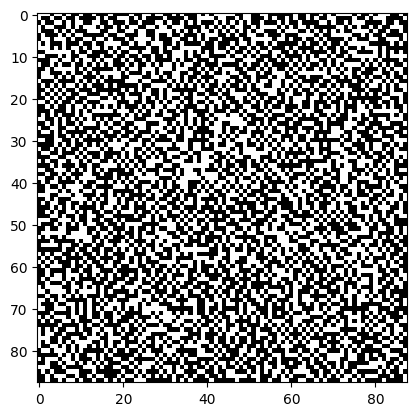

In [23]:
e_ads, e_des, e_diff, e_int_abs, e_int_des,lattice_size,T = best_params

kmc_model = KineticMonteCarlo(
    lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
    e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
    time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
)
occupancy = kmc_model.run_simulation()
print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

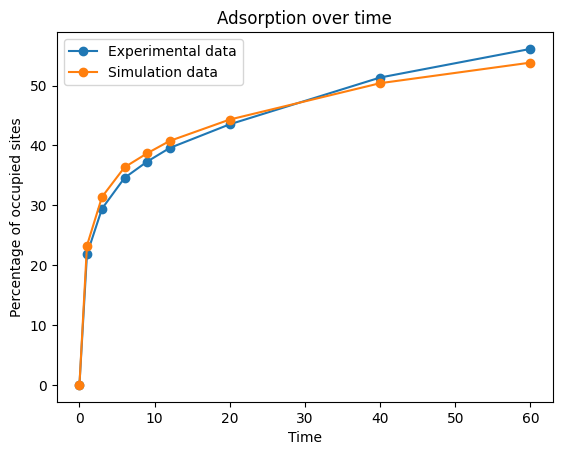

Mean Squared Error (MSE): 2.1307286390246754


In [24]:
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
k_ads   k_des   k_diff
{'adsorption': 6612, 'desorption': 0, 'diffusion': 1349}
Saturation:  54.08057851239669 %


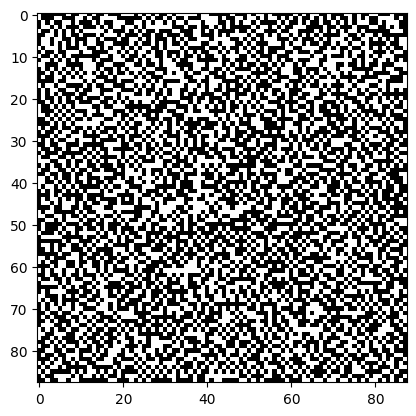

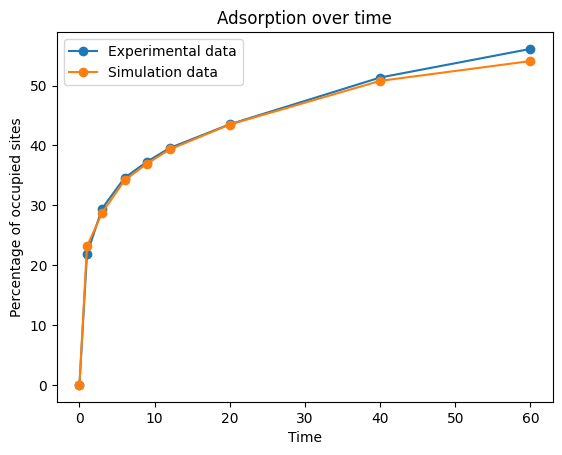

Mean Squared Error (MSE): 0.7837798563690471


In [25]:
while mse >= 1:
    e_ads, e_des, e_diff, e_int_abs, e_int_des,lattice_size,T = best_params

    kmc_model = KineticMonteCarlo(
        lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
        e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
        time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
    )
    occupancy = kmc_model.run_simulation()

    simulated_data = np.array(list(occupancy.values()))
    simulated_data[0] = 0
    mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)


print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

k_ads   k_des   k_diff


Text(0.5, 0, 'Tiempo (s)')

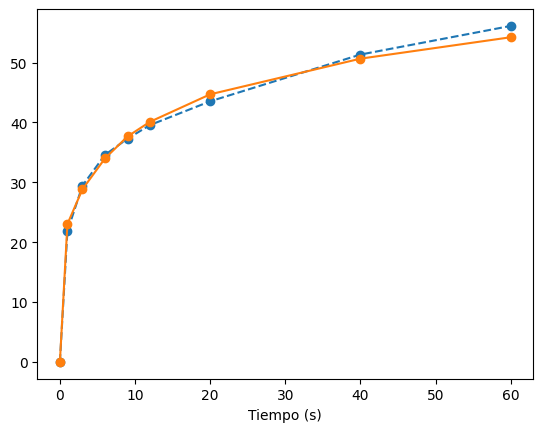

In [26]:
e_ads, e_des, e_diff, e_int_abs, e_int_des,lattice_size,T = best_params
kmc_model = KineticMonteCarlo(
        lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
        e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
        time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
    )
occupancy = kmc_model.run_simulation()

simulated_data = np.array(list(occupancy.values()))
plt.plot(time_array, exp_data, label="Datos experimentales", marker="o", linestyle="--")
plt.plot(time_array, simulated_data, label="Datos simulados", marker="o")
plt.xlabel("Tiempo (s)")

In [31]:
N = 100  # Número de simulaciones
curves = []
times = []

for _ in range(N):
    kmc_model = KineticMonteCarlo(
            lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
            e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
            time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
        )
    occupancy = kmc_model.run_simulation()
    curves.append(occupancy.values())
    times.append(kmc_model.time_array)

Mean values:  [ 0.         22.8786157  29.48179236 34.60240186 37.91838843 40.34271694
 44.83290289 50.88675103 54.08858471]
Standard deviation values:  [0.         1.67164153 1.23244618 1.10728348 0.88046303 0.80588106
 0.65824826 0.49193341 0.38287802]
Mean Squared Error (MSE): 0.9047832459128016


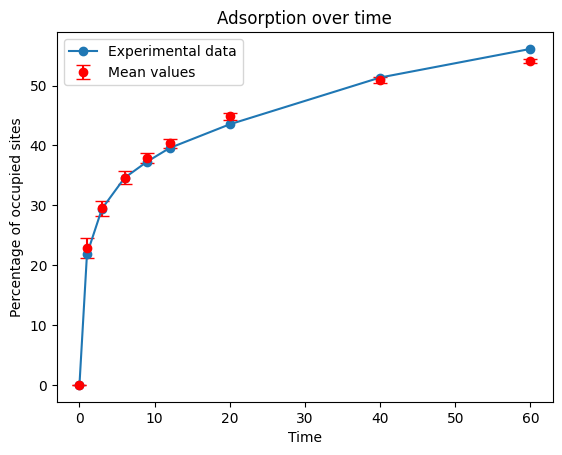

In [34]:
df = pd.DataFrame(curves)
mean_values = df.mean().to_numpy()
std_values = df.std().to_numpy()

print("Mean values: ", mean_values)
print("Standard deviation values: ", std_values)

plt.errorbar(time_array, mean_values, yerr=std_values, capsize=5, color='red', fmt='o', label='Mean values')
plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()

mse = np.mean((np.array(exp_data) - np.array(mean_values)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
